# Project Description

This notebook has a Machine Learning regression project to estimate the rate of population with some mental illness in counties of the U.S.

- **Author:** Francis Morales

- **Github Repository:** https://github.com/Francismorales/Machine_Learning_Regression_MentalIllness



**Project Objective:** 

Estimate the percentaje of population with mental illnesses in communities to help local governments and health organizations raise awareness and allocate resources in mental care to build better lives for those affected.


**Data Sourcing:** 

Details on the steps followed to source the data for this project can be found in data_sourcing.ipynb.

# Libraries

In [546]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
pd.options.display.max_rows = 100
import shapefile as shp
import geopandas as gpd
import matplotlib.patches as mpatches

#libraries to connect to API/source data
import json
import requests

#libraries for linear regression
from statsmodels.stats.outliers_influence import variance_inflation_factor


#libraries for ML regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [ ]:
#function to load API Key locally stored
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [389]:
def plot_feature_importances(model):
    """
    This function plots the feature importances of decision trees
    """
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [508]:
def print_base_map(shp_path, x_lim = None, y_lim = None, figuresize = (15,9), title = 'Plot'):
    """
    Function to plot map from a shapefile
    shp_path: shapefile path
    x_lim/y_lim: coordinate range to plot (optional)
    """
    shapef = shp.Reader(shp_path) #read shapefile
    fig, ax = plt.subplots(figsize = figuresize)
    fig.suptitle(title, fontsize=14)
    for shape in shapef.shapeRecords(): #BASE MAP
        x = [i[0] for i in shape.shape.points[:]] #fetch x coordinates from shapefile
        y = [i[1] for i in shape.shape.points[:]] #fetch y coordinates from shapefile
        plt.plot(x, y, 'k', linewidth=0.75) #plot each shape in file 
    if (x_lim != None) & (y_lim != None): #check if plot range was specified    
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    return(fig, ax)

# OBTAIN / SCRUB

## SAMHSA Data Labels

Data Labels were obtained from the Substance Abuse and Mental Health Services Administration (SAMHSA) website. The NSDHsubstateAgeGroupTabs2018.xlsx file was downloaded from this link:
https://www.samhsa.gov/data/report/2016-2018-nsduh-substate-region-estimates-age-group

**SURVEY**: 2016-2018 National Survey on Drug Use and Health (NSDUH): substate region estimates by age group

**Table 27**: Any Mental Illness in the Past Year, by Age Group and Substate Region: Percentages, Annual Averages Based on 2016, 2017, and 2018 NSDUHs  

**Column: 18 or Older Estimate** -- Adults with any mental illness 



I used the "2016-2018 National Survey on Drug Use and Health Substate Region Definitions" to obtain percentages on county-level: https://www.samhsa.gov/data/report/2016-2018-nsduh-substate-region-definitions





In [101]:
data_labels = pd.read_csv("DATA/mental_illness_percentage_ALL_COUNTIES.csv", encoding='latin-1') #IMPORT DATA

data_labels = data_labels.assign(newcounty=data_labels['county'].str.replace('.', '')) #remove . from county names if any
data_labels.drop(labels=['county'], inplace=True, axis=1)
data_labels.rename(columns={'newcounty': "county"}, inplace=True)

data_labels['county'] = data_labels['county'].apply(lambda x: x.upper())

data_labels.loc[data_labels['county'] == "DE KALB",'county'] = 'DEKALB' #for consistency across sources
data_labels.loc[data_labels['county'] == "LA PORTE",'county'] = 'LAPORTE' #for consistency across sources

In [102]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 4 columns):
state_name                   2986 non-null object
Substate                     2986 non-null object
mental_illness_percentage    2986 non-null float64
county                       2986 non-null object
dtypes: float64(1), object(3)
memory usage: 93.4+ KB


## US Census Bureau API

I used the US Census Bureau API to extract several variables for my study. 

I extracted the data from the **American Community Survey 5 Year Data (2009-2018)**. This survey covers topics about social, economic, demographic and housing characteristics of the U.S. population. There are over 20,000 variables in this dataset, but not many of the variables are available down to the county-level. 

See the **data_sourcing.ipynb** for details on the API call process. 

**Data Engineering:**

- travel time to work:xxx -- will be divided by the "total travel time to work" to get percentages
- own children under 18 years by family type and age -- will be divided by "total household type" to get the percentage of households with children present
- household type:xxx -- will be divided by the "total household type" to get percentages
- male xxx -- will be divided by "total male over 15years" to get percentages
- female xxx --  will be divided by "total female over 15years" to get percentages 
- women who had a birth in the past 12 months -- will be divided by "total female over 15years" to get percentages
- male schooling -- will be divided by "total male over 15years" to get percentages
- female schooling -- will be divided by "total female over 15years" to get percentages
- total income in the past 12 months at or above poverty level -- will be divided by "total income in the past 12 months"
- total income in the past 12 months below poverty level -- will be divided by "total income in the past 12 months"
- household with cash public assistance or food stamps/snap in the past year -- will be divided by "total household in the past 12 months with/without public assist or stamps"
- employed population 16 years and over -- will be divided by "total employment status 16 and over"
- housing tenure owner occupied -- will be divided by "housing units"
- housing tenure renter occupied -- will be divided by "housing units"
- no household computer -- will be divided by "total household type"
- no household internet access -- will be divided by "total household type"

- 40+ min travel to work -- will add "travel time to work:xxx" variables more than 40 min travel
- male Bachelor's degree or+ -- will add male bachelor's, master's and doctorate degree percentages
- female Bachelor's degree or+ -- will add female bachelor's, master's and doctorate degree percentages

In [103]:
ACS_data = pd.read_csv("DATA/ACS_alldata.csv") #IMPORT DATA
ACS_data.describe()

,median age male,median age female,total travel time to work,travel time to work: less than 5 minutes,travel time to work: 5 to 9 minutes,travel time to work: 10 to 14 minutes,travel time to work: 15 to 19 minutes,travel time to work: 20 to 24 minutes,travel time to work: 25 to 29 minutes,travel time to work: 30 to 34 minutes,...,total employment status 16 and over,employed population 16 years and over,housing units,housing tenure owner occupied,housing tenure renter occupied,median number of rooms,median contract rent,median monthly housing costs,no household computer,no household internet access
count,820.000000,820.000000,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,...,8.200000e+02,8.200000e+02,8.200000e+02,8.200000e+02,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.000000
mean,37.693537,40.351341,1.531463e+05,3259.429268,12726.656098,19484.818293,23590.789024,22621.980488,10337.031707,21941.478049,...,2.698929e+05,1.642535e+05,1.389697e+05,7.758804e+04,4.681929e+04,5.718902,825.234146,1035.553659,9074.068293,13370.535366
std,4.573430,4.879832,2.720294e+05,3627.055847,15979.243375,27750.245177,36826.378461,38993.123317,17944.326858,48111.358482,...,4.738973e+05,2.940385e+05,2.263825e+05,1.108746e+05,1.007216e+05,0.536776,278.491311,331.518843,14472.953543,22478.337424
min,24.200000,25.200000,1.636300e+04,71.000000,1072.000000,1387.000000,1451.000000,1082.000000,188.000000,920.000000,...,4.986000e+04,1.776300e+04,2.229300e+04,1.142000e+04,3.667000e+03,3.300000,343.000000,246.000000,564.000000,899.000000
25%,35.000000,37.500000,4.180225e+04,1324.500000,5107.750000,6667.500000,6601.250000,5382.000000,2341.750000,4357.500000,...,7.652575e+04,4.417725e+04,4.184575e+04,2.543100e+04,1.072725e+04,5.400000,633.000000,802.500000,3246.750000,4644.000000
50%,37.600000,40.100000,7.159150e+04,2232.000000,8061.000000,10840.000000,12120.500000,10357.000000,4521.000000,8171.000000,...,1.280875e+05,7.540600e+04,6.929200e+04,4.155550e+04,1.833950e+04,5.700000,754.500000,951.000000,4997.000000,7021.000000
75%,40.000000,43.100000,1.561410e+05,3752.500000,14380.000000,22336.750000,27641.750000,23500.750000,10793.750000,19508.250000,...,2.668648e+05,1.697750e+05,1.425125e+05,8.332400e+04,4.242600e+04,6.000000,949.000000,1189.750000,9159.250000,12997.000000
max,67.100000,67.800000,4.602960e+06,49549.000000,240524.000000,446289.000000,601944.000000,597200.000000,252799.000000,845618.000000,...,8.162030e+06,5.001369e+06,3.561342e+06,1.501284e+06,1.812624e+06,7.700000,2320.000000,2507.000000,219188.000000,346396.000000


In [104]:
#Data Engineering

#Calculate percentages
var_list = ['travel time to work: less than 5 minutes', 'travel time to work: 5 to 9 minutes', 'travel time to work: 10 to 14 minutes',
           'travel time to work: 15 to 19 minutes', 'travel time to work: 20 to 24 minutes', 'travel time to work: 25 to 29 minutes',
           'travel time to work: 30 to 34 minutes', 'travel time to work: 35 to 39 minutes', 'travel time to work: 40 to 44 minutes',
           'travel time to work: 45 to 59 minutes', 'travel time to work: 60 to 89 minutes', 'travel time to work: 90 or more minutes']
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total travel time to work']
    
var_list = ['household type: married-couple family', 'household type: male householder, no wife present', 
            'household type: female householder, no husband present', 'household type: householder living alone', 'household type: householder not living alone']
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total household type']
    
var_list = ['male never married', 'male now married', 'male widowed', 'male divorced']
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total male over 15years']

var_list = ['female never married', 'female now married', 'female widowed', 'female divorced']
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total female over 15 years']

var_list = ['male no schooling completed', 'male high school graduate (includes equivalency)', "male bachelor's degree", 
           "male master's degree", 'male doctorate degree']
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total male over 15years']

var_list = ['female no schooling completed', 'female high school graduate (includes equivalency)', "female bachelor's degree",
           "female master's degree", "female doctorate degree"]
for var in var_list:
    ACS_data[var] = ACS_data[var]/ACS_data['total female over 15 years']

ACS_data['own children under 18 years by family type and age'] = ACS_data['own children under 18 years by family type and age']/ACS_data['total household type']
ACS_data['women who had a birth in the past 12 months'] = ACS_data['women who had a birth in the past 12 months']/ACS_data['total female over 15 years']
ACS_data['total income in the past 12 months at or above poverty level'] = ACS_data['total income in the past 12 months at or above poverty level']/ACS_data['total income in the past 12 months']
ACS_data['total income in the past 12 months below poverty level'] = ACS_data['total income in the past 12 months below poverty level']/ACS_data['total income in the past 12 months']
ACS_data['employed population 16 years and over'] = ACS_data['employed population 16 years and over']/ACS_data['total employment status 16 and over']
ACS_data['household with cash public assistance or food stamps/snap in the past year'] = ACS_data['household with cash public assistance or food stamps/snap in the past year']/ACS_data['total household in the past 12 months with/without public assist or stamps']
ACS_data['housing tenure owner occupied'] = ACS_data['housing tenure owner occupied']/ACS_data['housing units']
ACS_data['housing tenure renter occupied'] = ACS_data['housing tenure renter occupied']/ACS_data['housing units']
ACS_data['no household computer'] = ACS_data['no household computer']/ACS_data['total household type']
ACS_data['no household internet access'] = ACS_data['no household internet access']/ACS_data['total household type'] 

ACS_data['40+ min travel to work'] = ACS_data['travel time to work: 40 to 44 minutes'] + ACS_data['travel time to work: 45 to 59 minutes'] + ACS_data['travel time to work: 60 to 89 minutes'] + ACS_data['travel time to work: 90 or more minutes']
ACS_data["male Bachelor's degree or+"] = ACS_data["male bachelor's degree"] + ACS_data["male master's degree"] + ACS_data['male doctorate degree']
ACS_data["female Bachelor's degree or+"] = ACS_data["female bachelor's degree"] + ACS_data["female master's degree"] + ACS_data['female doctorate degree']


#drop travel time variables
ACS_data.drop(labels=['travel time to work: less than 5 minutes', 'travel time to work: 5 to 9 minutes',
                          'travel time to work: 10 to 14 minutes', 'travel time to work: 15 to 19 minutes',
                          'travel time to work: 20 to 24 minutes', 'travel time to work: 25 to 29 minutes',
                          'travel time to work: 30 to 34 minutes', 'travel time to work: 35 to 39 minutes',
                          'travel time to work: 40 to 44 minutes', 'travel time to work: 45 to 59 minutes',
                          'travel time to work: 60 to 89 minutes', 'travel time to work: 90 or more minutes'], inplace=True, axis=1)
#drop education labels
ACS_data.drop(labels=['male doctorate degree', 'female doctorate degree',
                        "male master's degree", "female master's degree", "male bachelor's degree", "female bachelor's degree",
                       'male high school graduate (includes equivalency)', 'female high school graduate (includes equivalency)'], inplace=True, axis=1)

#drop "total" variables
ACS_data.drop(labels=['total travel time to work',
                        'total household type', 'total male over 15years','total female over 15 years','total income in the past 12 months', 
                        'total household in the past 12 months with/without public assist or stamps',
                        'total employment status 16 and over', 'housing units'], inplace=True, axis=1)


ACS_data.drop(labels=['household type: householder not living alone', 'household type: householder living alone', 
                        'male never married','male widowed', 'female never married','female widowed',
                        'total income in the past 12 months at or above poverty level','no household computer', 
                        'gini index', 'median household income in the past 12 months (in 2018 inflation-adjusted dollars)',
                     'male now married', 'female now married', 'median age male', 'median age female', 'male now married',
                     'female now married', 'median number of rooms', 'housing tenure owner occupied'], inplace=True, axis=1)

In [7]:
ACS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 25 columns):
NAME                                                                            820 non-null object
own children under 18 years by family type and age                              820 non-null float64
household type: married-couple family                                           820 non-null float64
household type: male householder, no wife present                               820 non-null float64
household type: female householder, no husband present                          820 non-null float64
male divorced                                                                   820 non-null float64
female divorced                                                                 820 non-null float64
women who had a birth in the past 12 months                                     820 non-null float64
male no schooling completed                                                     820 non-

## Weather Data

Monthly lowest temperatures and days of rain were obtained through web scrapping. Details on the web scraping process in the data_sourcing notebook.

In [105]:
weather = pd.read_csv("DATA/Rain&Temperaturedata.csv") #IMPORT DATA
weather['county'] = weather['county'].apply(lambda x: x.upper()) #for consistency across sources

#since there are multiple values of temperature/rain for a single county we need to transform the dataframe
weather_melted = pd.melt(weather, id_vars=['state_name', 'county', 'month'])
weather_melted['column_headers'] = weather_melted['month'] + "_" \
                                            + weather_melted['variable']
weather_melted.drop(labels=['variable', 'month'], inplace=True, axis=1)
weather_melted_pivot = pd.pivot_table(weather_melted, values='value', index=['state_name', 'county'], 
                                       columns=['column_headers'])
weather_final = pd.DataFrame(weather_melted_pivot.to_records())

#drop weather labels
weather_final.drop(labels=['August_days_of_rain', 'August_lowCelsius', 'December_days_of_rain',
                       'December_lowCelsius', 'February_days_of_rain', 'February_lowCelsius',
                       'June_days_of_rain', 'June_lowCelsius', 'March_days_of_rain', 'March_lowCelsius',
                       'May_days_of_rain', 'May_lowCelsius', 'November_days_of_rain', 'November_lowCelsius',
                       'septiembre_days_of_rain', 'septiembre_lowCelsius'], inplace=True, axis=1)

weather_final.head()

,state_name,county,April_days_of_rain,April_lowCelsius,January_days_of_rain,January_lowCelsius,July_days_of_rain,July_lowCelsius,October_days_of_rain,October_lowCelsius
0,Alabama,BALDWIN,5,12,8,4,11,22,4,13
1,Alabama,CALHOUN,7,10,8,1,9,21,5,11
2,Alabama,CULLMAN,7,8,7,-1,9,20,6,9
3,Alabama,DEKALB,8,9,9,0,10,19,7,10
4,Alabama,ELMORE,6,9,9,1,9,20,4,11


## Data Preparation

In [106]:
all_data = ACS_data.merge(data_labels, how='left', on=['state_name', 'county'])
# all_data.drop(labels=['Unnamed: 0'], inplace=True, axis=1)
all_data = all_data.merge(weather_final, how='left', on=['state_name', 'county'])
# all_data.head()

,NAME,own children under 18 years by family type and age,household type: married-couple family,"household type: male householder, no wife present","household type: female householder, no husband present",male divorced,female divorced,women who had a birth in the past 12 months,male no schooling completed,female no schooling completed,...,Substate,mental_illness_percentage,April_days_of_rain,April_lowCelsius,January_days_of_rain,January_lowCelsius,July_days_of_rain,July_lowCelsius,October_days_of_rain,October_lowCelsius
0,"Baldwin County, Alabama",0.464689,0.537970,0.026898,0.098047,0.157178,0.128073,0.014233,0.013890,0.003912,...,Region 4,0.2051,5,12,8,4,11,22,4,13
1,"Calhoun County, Alabama",0.417992,0.463063,0.063686,0.153488,0.127024,0.148566,0.037860,0.009195,0.010704,...,Region 2,0.2133,7,10,8,1,9,21,5,11
2,"Cullman County, Alabama",0.508195,0.553309,0.055403,0.103189,0.124033,0.130533,0.027695,0.011623,0.011210,...,Region 1,0.1995,7,8,7,-1,9,20,6,9
3,"DeKalb County, Alabama",0.542363,0.570705,0.053548,0.099350,0.078566,0.108773,0.045037,0.033790,0.007640,...,Region 1,0.1995,8,9,9,0,10,19,7,10
4,"Elmore County, Alabama",0.561234,0.564086,0.061947,0.106947,0.111522,0.106945,0.043447,0.005421,0.007289,...,Region 3,0.2087,6,9,9,1,9,20,4,11


In [107]:
#dataset without state name or county name
ml_all_data = all_data.copy()
ml_all_data.drop(labels=['NAME', 'state_name', 'county', 'Substate'], inplace=True, axis=1)
ml_all_data.isna().sum() #Check the number of NaNs in each column

own children under 18 years by family type and age                              0
household type: married-couple family                                           0
household type: male householder, no wife present                               0
household type: female householder, no husband present                          0
male divorced                                                                   0
female divorced                                                                 0
women who had a birth in the past 12 months                                     0
male no schooling completed                                                     0
female no schooling completed                                                   0
total income in the past 12 months below poverty level                          0
household with cash public assistance or food stamps/snap in the past year      0
per capita income in the past 12 months (in 2018 inflation-adjusted dollars)    0
mean usual hours

In [539]:
ml_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820 entries, 0 to 819
Data columns (total 31 columns):
own children under 18 years by family type and age                              820 non-null float64
household type: married-couple family                                           820 non-null float64
household type: male householder, no wife present                               820 non-null float64
household type: female householder, no husband present                          820 non-null float64
male divorced                                                                   820 non-null float64
female divorced                                                                 820 non-null float64
women who had a birth in the past 12 months                                     820 non-null float64
male no schooling completed                                                     820 non-null float64
female no schooling completed                                                   820 non

# Explore

## Multicollinearity check

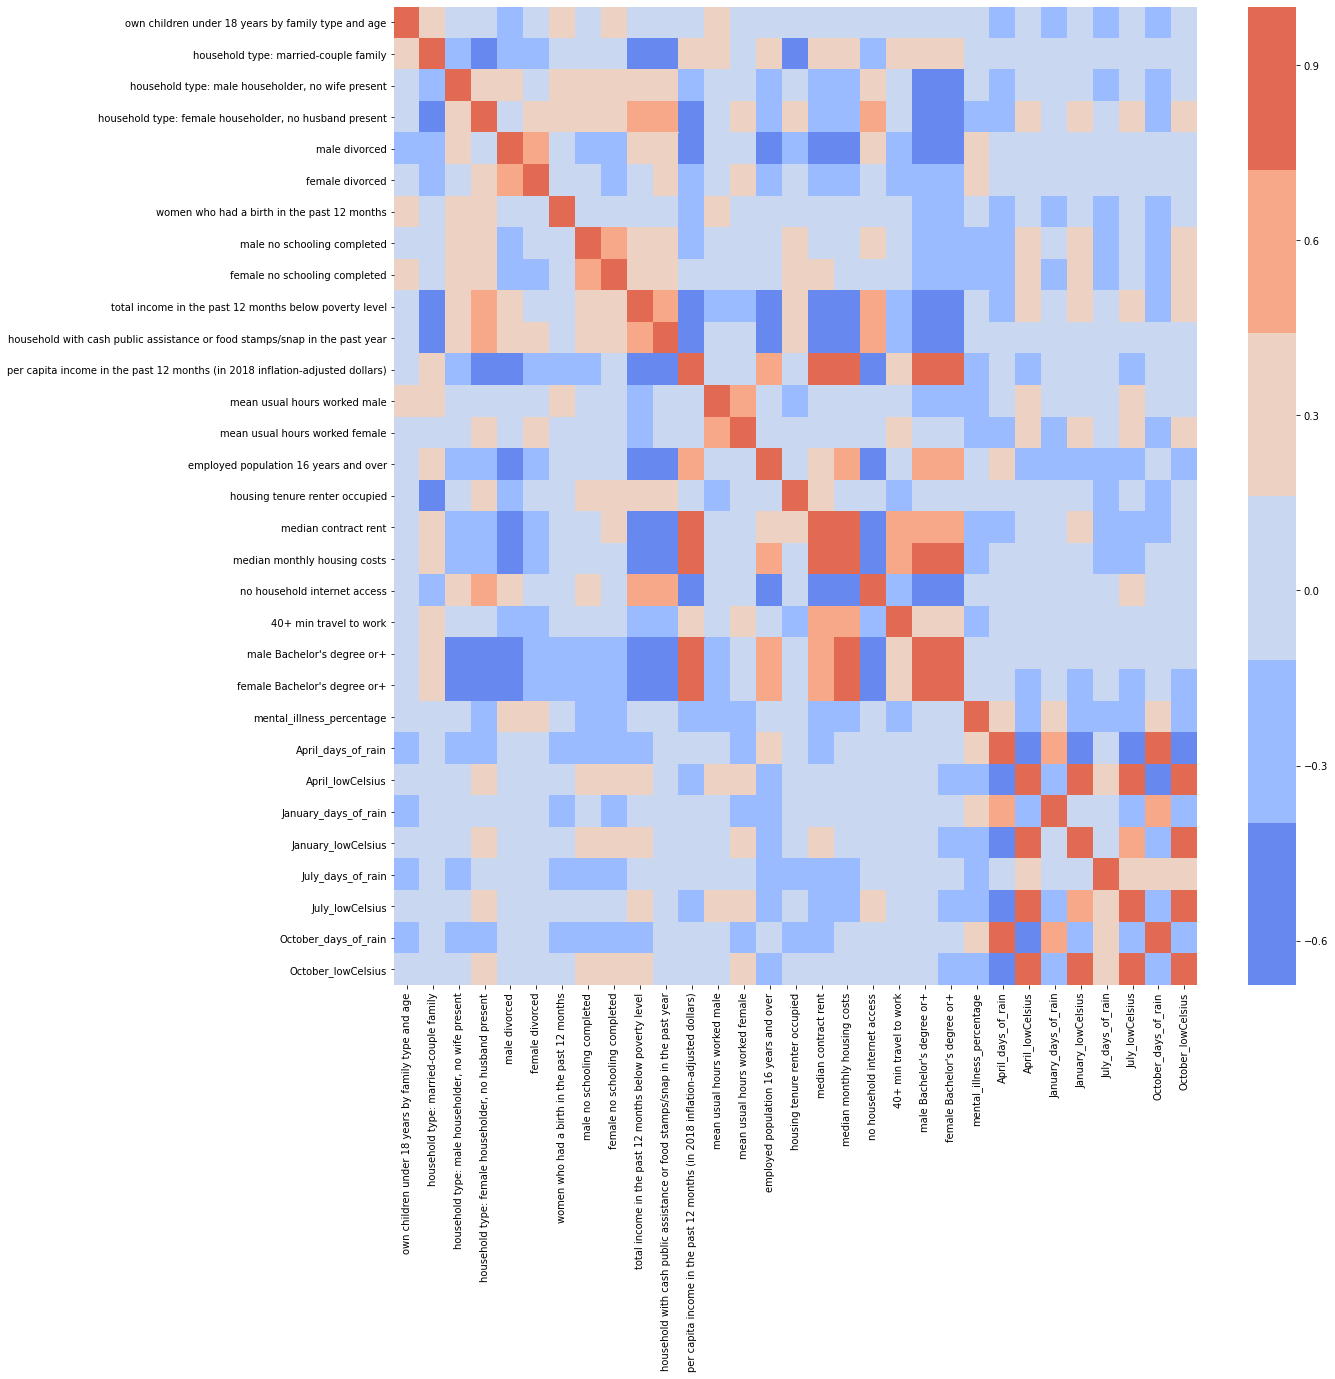

In [33]:
#Heatmap to check multicollinearity
corr = ml_all_data.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, annot=False, fmt='.1g', cmap=sns.color_palette('coolwarm'))
plt.show()

In [43]:
# Calculating VIF to evaluate multicollinearity
vif = pd.DataFrame() #create an empty dataframe
vif["variables"] = ml_all_data.columns
vif["VIF"] = [variance_inflation_factor(ml_all_data.values, i) for i in range(ml_all_data.shape[1])]
vif

,variables,VIF
0,own children under 18 years by family type and...,15.684753
1,household type: married-couple family,240.682575
2,"household type: male householder, no wife present",21.717254
3,"household type: female householder, no husband...",43.270649
4,male divorced,47.794707
5,female divorced,63.380004
6,women who had a birth in the past 12 months,13.334906
7,male no schooling completed,6.675395
8,female no schooling completed,6.881089
9,total income in the past 12 months below pover...,31.432566


Based on the heatmap and the VIF results, we can see that there is multicollinearity within several variables. I will keep this in mind when choosing the right model to solve my problem. 

## Data Distribution Check

<Figure size 1296x1296 with 0 Axes>

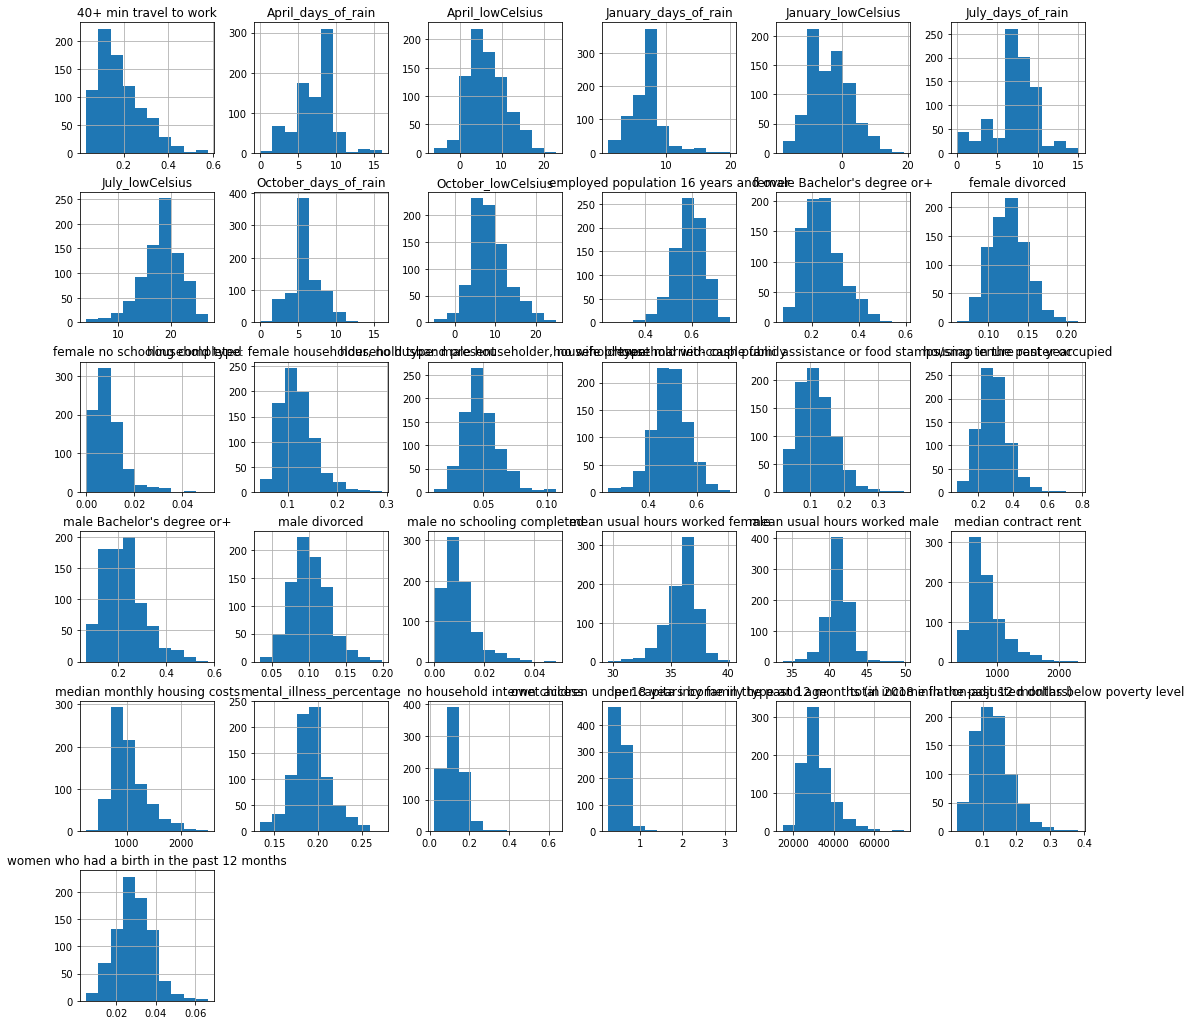

In [37]:
#Check the distribution of the variables
plt.figure(figsize=(18,18))
ml_all_data.hist(figsize=(18,18))
plt.show();

Not all of my variables have normal distribution. I will consider this when choosing my model.

**Mental Illness distribution**

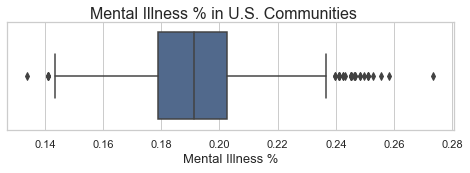

In [574]:
plt.figure(figsize=(8,2))
sns.set(style="whitegrid")
ax = sns.boxplot(x=all_data['mental_illness_percentage'], color="#476796")
ax.set_xlabel("Mental Illness %", fontsize=13)
plt.suptitle('Mental Illness % in U.S. Communities', fontsize=16)
plt.subplots_adjust(top=0.88)

25% of the counties have over 20% population that has experienced some type of mental illness 

## Mental Illness vs Variables

**Mental Illness vs Mean hours worked - male/female**

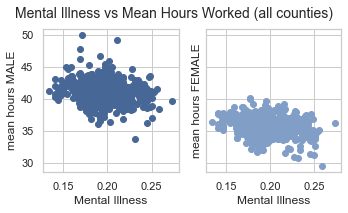

In [205]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(5,3), sharex=True, sharey=True)
axs[0].scatter(all_data['mental_illness_percentage'], all_data['mean usual hours worked male'], color='#476796')
axs[0].set_ylabel('mean hours MALE', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(all_data['mental_illness_percentage'], all_data['mean usual hours worked female'], color='#819ec7')
axs[1].set_ylabel('mean hours FEMALE', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Mean Hours Worked (all counties)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

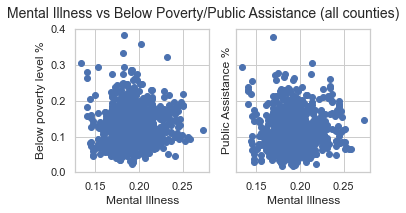

In [260]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(5,3), sharex=True, sharey=True)
axs[0].scatter(all_data['mental_illness_percentage'], all_data["total income in the past 12 months below poverty level"])
axs[0].set_ylabel('Below poverty level %', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(all_data['mental_illness_percentage'], all_data["household with cash public assistance or food stamps/snap in the past year"])
axs[1].set_ylabel('Public Assistance %', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Below Poverty/Public Assistance (all counties)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

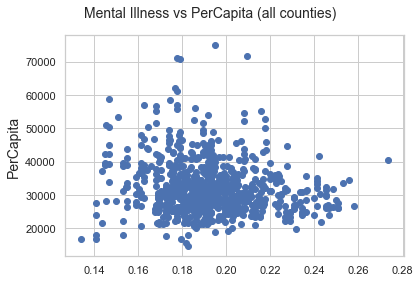

In [255]:
plt.scatter(all_data['mental_illness_percentage'], all_data['per capita income in the past 12 months (in 2018 inflation-adjusted dollars)'])
plt.ylabel('PerCapita', fontsize=14)
plt.suptitle('Mental Illness vs PerCapita (all counties)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

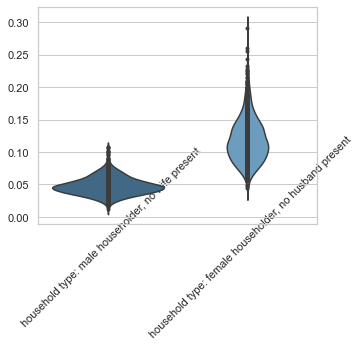

In [332]:
plt.figure(figsize=(5,4))
vp = ml_all_data[['household type: male householder, no wife present', 'household type: female householder, no husband present']]
sns.violinplot(data=vp, inner="points", palette="Blues_d")
plt.xticks(rotation=45, wrap=True)

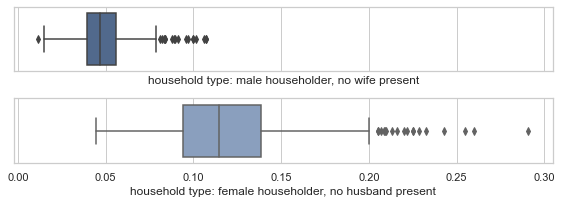

In [342]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,3), sharex=True, sharey=False)
sns.boxplot(x=all_data['household type: male householder, no wife present'], ax=ax1, color='#476796')
sns.boxplot(x=all_data['household type: female householder, no husband present'], ax=ax2, color='#819ec7')
plt.tight_layout()

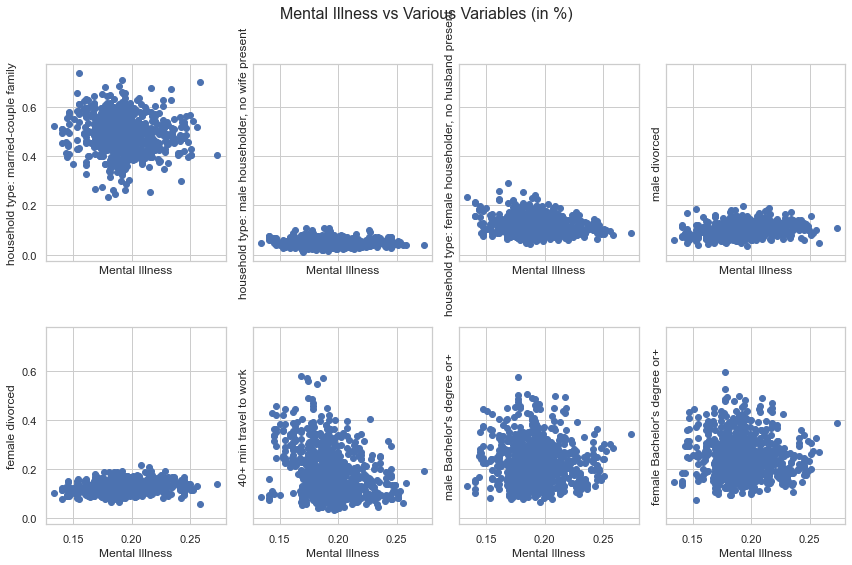

In [407]:
#x-axis: mental illness percentage
#y-axis: several different variables
variables = ['household type: married-couple family', 
             'household type: male householder, no wife present', 'household type: female householder, no husband present',
            'male divorced', 'female divorced', '40+ min travel to work', "male Bachelor's degree or+", "female Bachelor's degree or+"]

fig, axs = plt.subplots(2,4, figsize=(12,8), sharex=True, sharey=True)
for i, var in enumerate(variables):
    axs[i // 4,i % 4].scatter(all_data['mental_illness_percentage'], all_data[var])
    axs[i // 4,i % 4].set_ylabel(var)
    axs[i // 4,i % 4].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Various Variables (in %)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

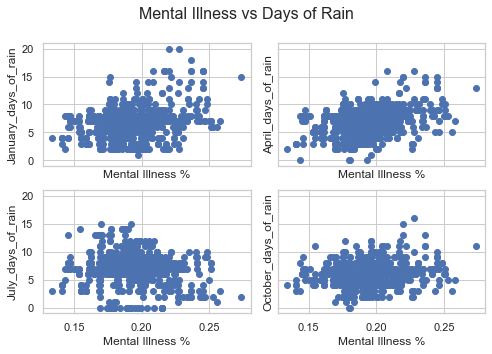

In [405]:
#x-axis: mental illness percentage
#y-axis: days of rain variables 
variables = ['January_days_of_rain','April_days_of_rain', 'July_days_of_rain', 'October_days_of_rain']

fig, axs = plt.subplots(2,2, figsize=(7,5), sharex=True, sharey=True)
for i, var in enumerate(variables):
    axs[i // 2,i % 2].scatter(all_data['mental_illness_percentage'], all_data[var])
    axs[i // 2,i % 2].set_ylabel(var)
    axs[i // 2,i % 2].set_xlabel("Mental Illness %")
    
fig.suptitle('Mental Illness vs Days of Rain', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

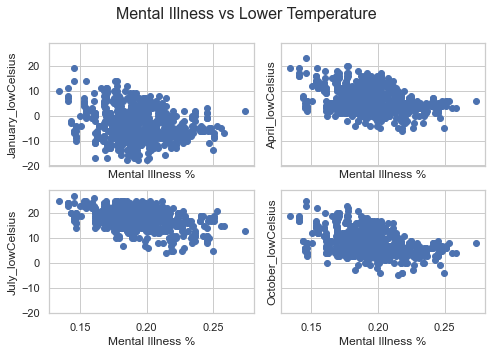

In [478]:
#x-axis: mental illness percentage
#y-axis: lowCelsius variables 
variables = ['January_lowCelsius','April_lowCelsius', 'July_lowCelsius', 'October_lowCelsius']

fig, axs = plt.subplots(2,2, figsize=(7,5), sharex=True, sharey=True)
for i, var in enumerate(variables):
    axs[i // 2,i % 2].scatter(all_data['mental_illness_percentage'], all_data[var])
    axs[i // 2,i % 2].set_ylabel(var)
    axs[i // 2,i % 2].set_xlabel("Mental Illness %")
    
fig.suptitle('Mental Illness vs Lower Temperature', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Lower quartile vs Upper quartile

In [209]:
all_data['mental_illness_percentage'].quantile([0.25,0.5,0.75])

0.25    0.178975
0.50    0.191400
0.75    0.202625
Name: mental_illness_percentage, dtype: float64

In [215]:
lower_q = all_data.loc[all_data['mental_illness_percentage'] < 0.178975]
upper_q = all_data.loc[all_data['mental_illness_percentage'] > 0.202625]

**DIVORCE RATES**

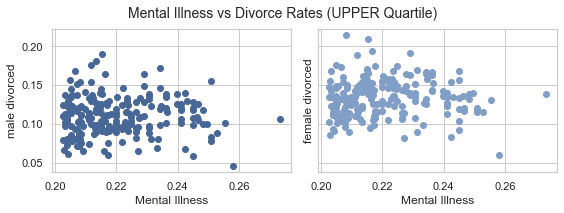

In [262]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
axs[0].scatter( upper_q['mental_illness_percentage'], upper_q["male divorced"], color='#476796')
axs[0].set_ylabel('male divorced', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(upper_q['mental_illness_percentage'], upper_q["female divorced"], color='#819ec7')
axs[1].set_ylabel('female divorced', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Divorce Rates (UPPER Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

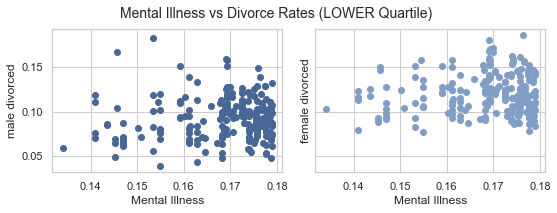

In [263]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
axs[0].scatter( lower_q['mental_illness_percentage'], lower_q["male divorced"], color='#476796')
axs[0].set_ylabel('male divorced', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(lower_q['mental_illness_percentage'], lower_q["female divorced"], color='#819ec7')
axs[1].set_ylabel('female divorced', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Divorce Rates (LOWER Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

HOURS WORKED

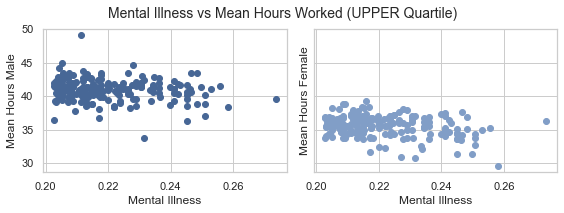

In [266]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
axs[0].scatter( upper_q['mental_illness_percentage'], upper_q["mean usual hours worked male"], color='#476796')
axs[0].set_ylabel('Mean Hours Male', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(upper_q['mental_illness_percentage'], upper_q["mean usual hours worked female"], color='#819ec7')
axs[1].set_ylabel('Mean Hours Female', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Mean Hours Worked (UPPER Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

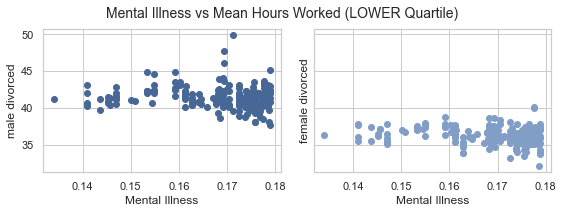

In [267]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
axs[0].scatter( lower_q['mental_illness_percentage'], lower_q["mean usual hours worked male"], color='#476796')
axs[0].set_ylabel('male divorced', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(lower_q['mental_illness_percentage'], lower_q["mean usual hours worked female"], color='#819ec7')
axs[1].set_ylabel('female divorced', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Mean Hours Worked (LOWER Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

**PER CAPITA**

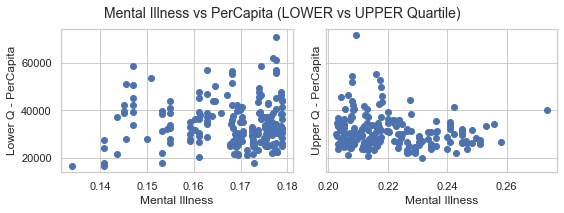

In [269]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
axs[0].scatter( lower_q['mental_illness_percentage'], lower_q["per capita income in the past 12 months (in 2018 inflation-adjusted dollars)"])
axs[0].set_ylabel('Lower Q - PerCapita', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(upper_q['mental_illness_percentage'], upper_q["per capita income in the past 12 months (in 2018 inflation-adjusted dollars)"])
axs[1].set_ylabel('Upper Q - PerCapita', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs PerCapita (LOWER vs UPPER Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

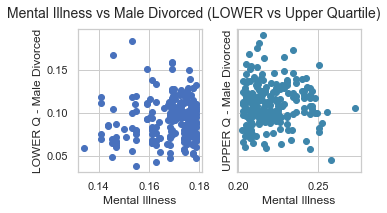

In [270]:
#x-axis: mental illness percentage
#y-axis: several different variables
fig, axs = plt.subplots(1,2, figsize=(5,3), sharex=False, sharey=True)
axs[0].scatter(lower_q['mental_illness_percentage'], lower_q["male divorced"], color='#4871bd')
axs[0].set_ylabel('LOWER Q - Male Divorced', fontsize=12)
axs[0].set_xlabel("Mental Illness")

axs[1].scatter(upper_q['mental_illness_percentage'], upper_q["male divorced"], color='#3e86ab')
axs[1].set_ylabel('UPPER Q - Male Divorced', fontsize=12)
axs[1].set_xlabel("Mental Illness")
    
fig.suptitle('Mental Illness vs Male Divorced (LOWER vs Upper Quartile)', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

## Maps using Shapefile

This map was created using shapefiles downloaded from the United States Census Bureau

Shapefile source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

State code source (STATEFP): https://www.census.gov/library/reference/code-lists/ansi.html#par_textimage_3

I adapted instructions on this tutorial to create the map: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [505]:
#shapefile definition
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile

In [506]:
#This file helps to get state names based on code from Census Bureau
STATEFP_codes = pd.read_csv('Shapefile_USA\Shapefile_STATEFPcodes.csv') #state name codes downloaded from US Census Bureau
STATEFP_codes.drop(labels=['STATENS'], inplace=True, axis=1)
STATEFP_codes['STATEFP'] = STATEFP_codes['STATEFP'].astype(str) #convert to string
STATEFP_codes['STATEFP'] = STATEFP_codes['STATEFP'].apply(lambda x: '{0:0>2}'.format(x)) #add leading zeros

In [531]:
#Prepare dataframe for USA-County Maps
fields = [x[0] for x in shapef.fields][1:] #fetching shapefile headings
records = [list(i) for i in shapef.records()]  #fetching shapefile records
shps = [s.points for s in shapef.shapes()]  #fetching shapefile coordinates
df_spf = pd.DataFrame(columns=fields, data=records) #converting into pandas dataframe
df_spf = df_spf.assign(coords=shps) #add a column with the coordinates
df_spf = df_spf.merge(STATEFP_codes, on=['STATEFP'], how='left') #add state name/abbrev to df
df_spf.rename(columns={'NAME': 'county'}, inplace=True) #rename column for naming convention

#DATA ENGINEERING to ensure consistent county names with other data sources
df_spf = df_spf.assign(newcounty=df_spf['county'].str.replace('.', '')) #remove . from county names if any
df_spf.drop(labels=['county'], inplace=True, axis=1)
df_spf.rename(columns={'newcounty': 'county'}, inplace=True) 
df_spf.loc[df_spf['county'] == 'Doña Ana','county'] = 'Dona Ana' #for consistency across sources
df_spf.at[1697, 'county'] = 'St Louis City' #for consistency across sources
df_spf.at[1889, 'county'] = 'Baltimore City' #for consistency across sources
df_spf.at[2579, 'county'] = 'Richmond City' #for consistency across sources
df_spf.at[2893, 'county'] = 'Roanoke City' #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Hampton') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Hampton City'  #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Norfolk') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Norfolk City'  #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Suffolk') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Suffolk City'  #for consistency across sources
indexes = df_spf.loc[df_spf['county'].isin(['Alexandria', 'Chesapeake', 'Newport News', 'Lynchburg', 'Portsmouth', 'Virginia Beach'])].index
for i, ind in enumerate(indexes):
    df_spf.at[ind, 'county'] = df_spf.at[ind, 'county'] + ' City' #for consistency across sources
df_spf['county'] = df_spf['county'].apply(lambda x: x.upper()) #for consistency across sources

df_spf = pd.merge(df_spf, all_data[['county', 'state_name', 'mental_illness_percentage']], \
                  on=['county', 'state_name'], how='left') # add diabetes_rank & McDonalds to define color in map

df_spf.loc[df_spf['mental_illness_percentage'].isnull(), 'mental_illness_percentage'] = 500 #pointer to identify the counties out of scope
df_spf['mental_level'] = df_spf['mental_illness_percentage'].apply(lambda x: 'ooo' if x == 500 else ('High' if x > 0.192497 else 'Low'))


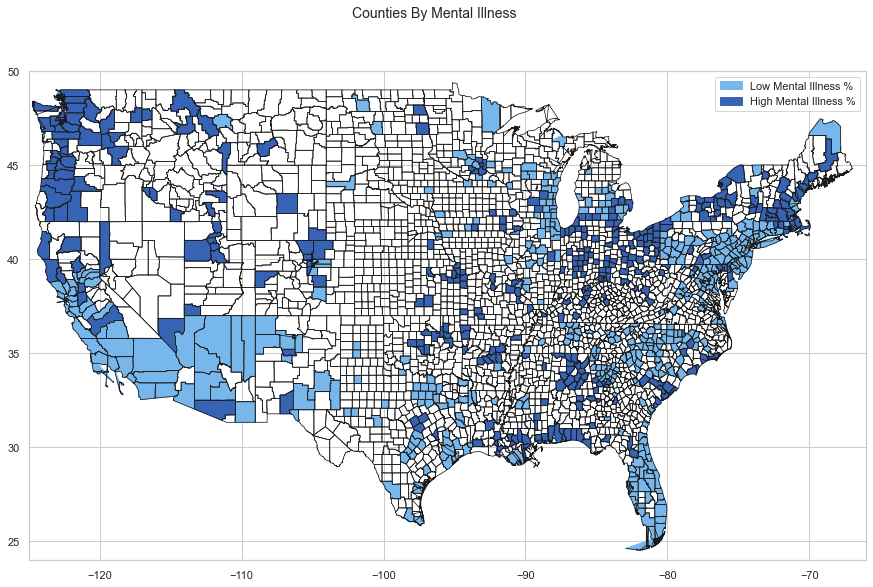

In [538]:
#color counties in scope based on diabetes rank
#since diabetes rank is a categorical variable, will manually set the corresponding colors
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile 
fig, ax = print_base_map(shp_path, (-125,-66), (24,50), title='Counties By Mental Illness') #use function for base map 

for r in range(0, len(df_spf)-1): #COLOR COUNTIES IN SCOPE
    rank = df_spf.at[r,'mental_level'] #based on dataframe index, fetch diabetes rank
    shape_ex = shapef.shape(r) #fetch shape coords by index
    x_longit, y_latit = [], [] #store latitude & longitude in separate lists
    for coord in range(len(shape_ex.points)): #split x/y coordinates
        x_longit.append(shape_ex.points[coord][0]) 
        y_latit.append(shape_ex.points[coord][1])
    if rank == "High":
        ax.fill(x_longit,y_latit, color='#3663b3', label='High')
    elif rank == "Low":
        ax.fill(x_longit,y_latit, color='#78b7eb', label='Low')  
        
high_patch = mpatches.Patch(color='#3663b3', label='High Mental Illness %')
low_patch = mpatches.Patch(color='#78b7eb', label='Low Mental Illness %')
plt.legend(handles=[low_patch, high_patch ])
plt.show();

# Hypothesis Testing

I will perform some hypothesis testing to analyze the dataset and variables further.

I will use one-tailed hypothesis testing since I will be trying to show that the sample mean would be higher or lower than the population mean.

In [470]:
#calculate the "population" mean
population_mean = all_data['mental_illness_percentage'].mean()
population_mean

0.19249756097560938

### H1: There is less mental illness in counties with higher number of married-couple households

 
 

- $H_0: \mu >= 0.19249756097560938 $ There is same or more mental illness in counties with higher number of married-couple households
- $H_a: \mu < 0.19249756097560938 $ There is lesser mental illness in counties with higher number of married-couple households

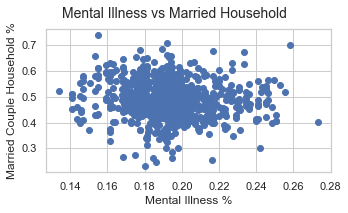

In [432]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['household type: married-couple family'])
plt.ylabel('Married Couple Household %', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs Married Household', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

Divide dataset by married-household median and determine if the difference between groups is due to chance or if it is significant

In [350]:
all_data['household type: married-couple family'].median()

0.48914765233578983

In [500]:
higher_marriedhousehold = all_data.loc[all_data['household type: married-couple family'] > 0.48914765233578983]
higher_marriage_mean = higher_marriedhousehold['mental_illness_percentage'].mean()
print("Mean Mental Illness for Higher Married-Households = {}".format(higher_marriage_mean))

Mean Mental Illness for Higher Married-Households = 0.1903434146341463


**Monte Carlo Simulation**

In [501]:
#sample from high-marriage counties and check the probability of mental illness percentage 
#being lower than the mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_marriedhousehold.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean < population_mean:
        counter += 1

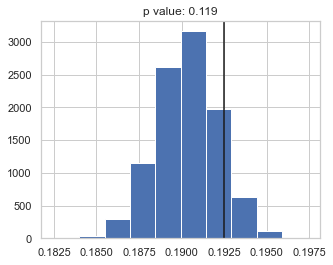

In [502]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1 - np.round(counter / 10000, 3)}');

**Conclusion**

> p-value > 0.05, so I DO NOT have significant evidence to reject H0, therefore I can conclude that there is SAME OR MORE percentage of population with some kind of mental illness in counties with higher number of marriages

### H2: There is lesser mental illness in counties with high commute time

- $H_0: \mu >= 0.19249756097560938 $ There is the same or more mental illness for counties with high commute
- $H_a: \mu < 0.19249756097560938 $ There is lesser mental illness in counties with high commute

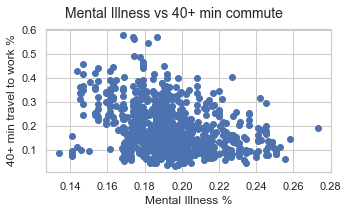

In [576]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['40+ min travel to work'])
plt.ylabel('40+ min travel to work %', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs 40+ min commute', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

Divide dataset by 40+ min travel to work median and determine if the difference between groups is due to chance or if it is significant using a Monte Carlo simulation

In [362]:
all_data['40+ min travel to work'].median()

0.1643788448352966

In [497]:
higher_commute = all_data.loc[all_data['40+ min travel to work'] > 0.1643788448352966]
higher_commute_mean = higher_commute['mental_illness_percentage'].mean()
print("Mean higher commute = {}".format(higher_commute_mean))

Mean higher commute = 0.18824804878048776


**Monte Carlo Simulation**

In [498]:
#sample from high-commute counties and check the probability of mental illness percentage 
#being lower than the total population mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_commute.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean < population_mean:
        counter += 1

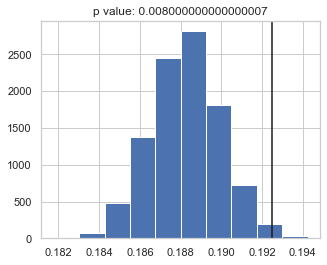

In [499]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1 - np.round(counter / 10000, 3)}');

**Conclusion**

> p-value < 0.05, so I have significant evidence to REJECT H0, therefore I can conclude that there is LESS percentage of population with some kind of mental illness in counties with higher commute

### H3: There is higher mental illness in counties with more rainy days in April

- $H_0: \mu <= 0.19249756097560938 $ Mental Illness is the same for counties with more rainy days in April
- $H_a: \mu > 0.19249756097560938 $ There is higher mental illness in counties with more rainy days in April

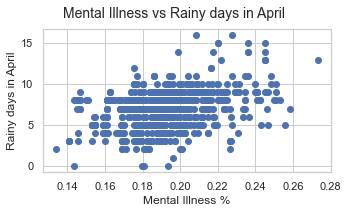

In [485]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['April_days_of_rain'])
plt.ylabel('Rainy days in April', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs Rainy days in April', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

Divide dataset by April_days_of_rain median and determine if the difference between groups is due to chance or if it is significant using a Monte Carlo simulation.

In [486]:
all_data['April_days_of_rain'].median()

7.0

In [487]:
higher_rain = all_data.loc[all_data['April_days_of_rain'] > 7]
higher_rain_mean = higher_rain['mental_illness_percentage'].mean() 
print("Higher Rain MI mean = {}".format(higher_rain_mean))

Higher Rain MI mean = 0.19750968586387443


**Monte Carlo Simulation**

In [488]:
#sample from high-rain in April counties and check the probability of mental illness percentage 
#being higher than the total population mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_rain.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean > population_mean:
        counter += 1

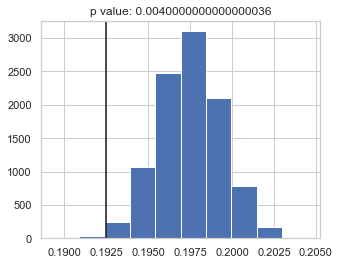

In [489]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

**Conclusion**

> p-value < 0.05, so I have significant evidence to REJECT H0, therefore I can conclude that there is MORE percentage of population with some kind of mental illness in counties with higher number of rainy days in April (population mental illness mean is < April rainy days +7 mental illness mean)

**October and July**

In [592]:
all_data['October_days_of_rain'].median()

6.0

In [588]:
higher_rain = all_data.loc[all_data['October_days_of_rain'] > 6]
higher_rain_mean = higher_rain['mental_illness_percentage'].mean() 
print("Higher Rain MI mean = {}".format(higher_rain_mean))

Higher Rain MI mean = 0.19769516728624537


In [589]:
sample_means = []
counter = 0

for i in range(10000):
    sample = higher_rain.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean > population_mean:
        counter += 1

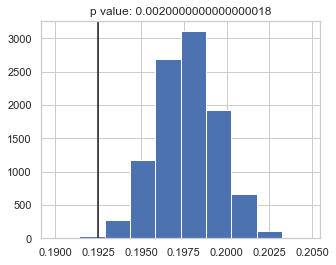

In [590]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

In [593]:
all_data['July_days_of_rain'].median()

7.0

In [594]:
higher_rain = all_data.loc[all_data['July_days_of_rain'] > 7]
higher_rain_mean = higher_rain['mental_illness_percentage'].mean() 
print("Higher Rain MI mean = {}".format(higher_rain_mean))

Higher Rain MI mean = 0.19164421593830333


In [595]:
sample_means = []
counter = 0

for i in range(10000):
    sample = higher_rain.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean > population_mean:
        counter += 1

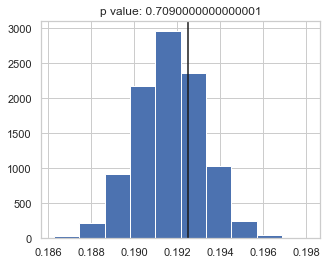

In [596]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

**Conclusion**

> October rainy days affect mental illness rates. There is no significant evidence to say the same for July

### H4: There is higher mental illness in counties with more rainy days in January

- $H_0: \mu <= 0.19249756097560938 $ Mental Illness is the same for counties with more rainy days in January
- $H_a: \mu > 0.19249756097560938 $ There is higher mental illness in counties with more rainy days in January

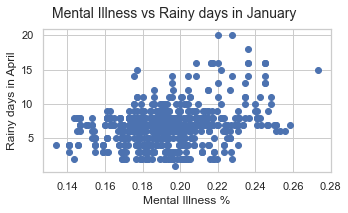

In [578]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['January_days_of_rain'])
plt.ylabel('Rainy days in April', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs Rainy days in January', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

In [579]:
all_data['January_days_of_rain'].median()

7.0

In [580]:
higher_rain = all_data.loc[all_data['January_days_of_rain'] > 7]
higher_rain_mean = higher_rain['mental_illness_percentage'].mean() 
print("Higher Rain MI mean = {}".format(higher_rain_mean))

Higher Rain MI mean = 0.19700529801324512


**Monte Carlo Simulation**

In [581]:
#sample from high-rain in January counties and check the probability of mental illness percentage 
#being higher than the total population mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_rain.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean > population_mean:
        counter += 1

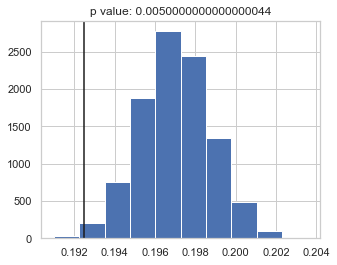

In [582]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

**Conclusion**

> p-value < 0.05, so I have significant evidence to REJECT H0, therefore I can conclude that there is MORE percentage of population with some kind of mental illness in counties with higher number of rainy days in January (population mental illness mean is < January rainy days +7 mental illness mean)

### H4: There is less mental illness in counties with more female mean working hours

- $H_0: \mu >= 0.19249756097560938 $ Mental Illness is the same or higher than population average for counties with more female mean working hours
- $H_a: \mu < 0.19249756097560938 $ There is lesser mental illness in counties with more female mean working hours

In [469]:
#calculate the "population" mean
population_mean = all_data['mental_illness_percentage'].mean()
population_mean

0.19249756097560938

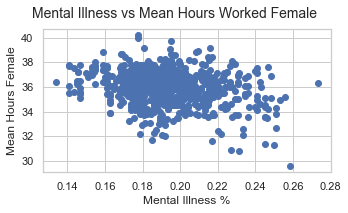

In [472]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['mean usual hours worked female'])
plt.ylabel('Mean Hours Female', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs Mean Hours Worked Female', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

Divide dataset by mean usual hours worked female median and determine if the difference between groups is due to chance or if it is significant using a Monte Carlo simulation.

In [490]:
all_data['mean usual hours worked female'].median()

36.2

In [491]:
higher_femalehours = all_data.loc[all_data['mean usual hours worked female'] > 36.2]
higher_femalehours_mean = higher_femalehours['mental_illness_percentage'].mean() 
print("Higher female hours MI mean = {}".format(higher_femalehours_mean))

Higher female hours MI mean = 0.18923520408163286


In [492]:
#sample from high-female hours counties and check the probability of mental illness percentage 
#being lesser than the total population mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_femalehours.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean < population_mean:
        counter += 1

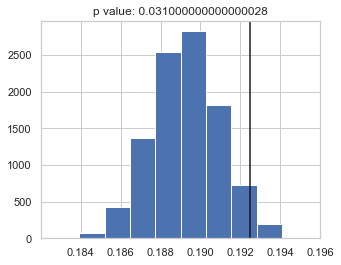

In [493]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

**Conclusion**

> p-value < 0.05, so I have significant evidence to REJECT H0, therefore I can conclude that there is LESS percentage of population with some kind of mental illness in counties with higher mean female working hours

### H5: There is less mental illness in counties with more male mean working hours

- $H_0: \mu >= 0.19249756097560938 $ Mental Illness is the same or higher than population average for counties with more male mean working hours
- $H_a: \mu < 0.19249756097560938 $ There is lesser mental illness in counties with more male mean working hours

In [479]:
all_data['mean usual hours worked male'].median()

41.2

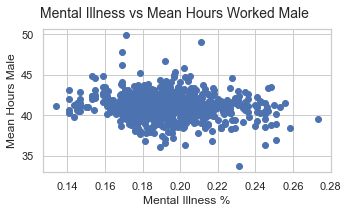

In [577]:
plt.figure(figsize=(5,3))
plt.scatter(all_data['mental_illness_percentage'], all_data['mean usual hours worked male'])
plt.ylabel('Mean Hours Male', fontsize=12)
plt.xlabel('Mental Illness %', fontsize=12)
plt.suptitle('Mental Illness vs Mean Hours Worked Male', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

In [494]:
higher_malehours = all_data.loc[all_data['mean usual hours worked male'] > 41.2]
higher_malehours_mean = higher_malehours['mental_illness_percentage'].mean() 
print("Higher male hours MI mean = {}".format(higher_malehours_mean))

Higher male hours MI mean = 0.19045538461538464


In [495]:
#sample from high-female hours counties and check the probability of mental illness percentage 
#being lesser than the total population mental illness mean percentage

sample_means = []
counter = 0

for i in range(10000):
    sample = higher_malehours.sample(replace=False, n=100) 
    sample_mean = sample['mental_illness_percentage'].mean()
    sample_means.append(sample_mean)
    if sample_mean < population_mean:
        counter += 1

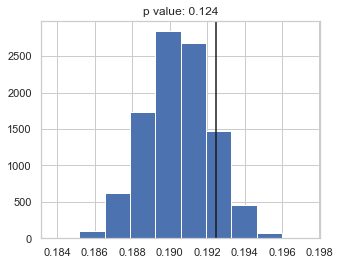

In [496]:
plt.figure(figsize=(5,4))
plt.hist(sample_means)
plt.axvline(population_mean, color = 'k')
plt.title(f'p value: {1- np.round(counter / 10000, 3)}');

**Conclusion**

> p-value > 0.05, so I DO NOT have significant evidence to reject H0, therefore I can conclude that there is SAME OR MORE percentage of population with some kind of mental illness in counties with higher mean male working hours

# Model - Machine Learning

I will split my dataset into two folds: train and test.
I also used the MinMaxScaler (instead of the standard scaler) since some of my variables are not gaussian.

My dependent variable is already between 0 and 1, so no need to scale it.

In [413]:
X = ml_all_data.copy()
X.drop(labels=['mental_illness_percentage'], inplace=True, axis=1)
y = ml_all_data['mental_illness_percentage']
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

### Baseline Model

Calculate RMSE of a model that always predicts the median of the training dependent variable. Remember that the RMSE is in the same units as the dependent variable.

In [551]:
y_baseline = []
y_baseline.extend([y_train.median()] * len(y_train))

r2 = r2_score(y_train, y_baseline)

print("RMSE - Baseline Model: {}".format(np.sqrt(mean_squared_error(y_train, y_baseline))))
print("R2 = {}".format(r2))

RMSE - Baseline Model: 0.021073827419113796
R2 = -0.0012605378868615347


### SVR

SVR - Support Vector Regressor

This is a non-parametric algorithm, therefore we do not need to meet assumptions (i.e: Linear Regression needs to meet the Gauss-Markov assumptions)

In SVR a margin of tolerance (epsilon) is set in approximation to the SVM

In [54]:
# Create the grid parameter
grid = {'svr__kernel': ['rbf'],
         'svr__C': [0.03, 0.05, 0.07, 0.1, 1],
         'svr__epsilon': [0.003, 0.005, 0.01, 0.05],
         'svr__gamma': [0.001, 0.005, 0.1, 1]}

#this grid has the default gamma
grid2 = {'svr__kernel': ['rbf'],
         'svr__C': [0.03, 0.05, 0.07, 0.1, 1],
         'svr__epsilon': [0.001, 0.003, 0.005, 0.01, 0.05]}


# Create the grid, with "pipe" as the estimator
SVR1_gridsearch = GridSearchCV(estimator=Pipeline([('pca', PCA(n_components=20)),
                                    ('svr', svm.SVR())]),
                                    param_grid=grid,
                                    scoring='r2',
                                    cv=10)
SVR2_gridsearch = GridSearchCV(estimator=Pipeline([('svr', svm.SVR())]),
                                    param_grid=grid2,
                                    scoring='r2',
                                    cv=10)
SVR3_gridsearch = GridSearchCV(estimator=Pipeline([('pca', PCA(n_components=20)),
                                    ('svr', svm.SVR())]),
                                    param_grid=grid2,
                                    scoring='r2',
                                    cv=10)

SVMgrids = [SVR1_gridsearch, SVR2_gridsearch, SVR3_gridsearch]
for g in SVMgrids:
    g.fit(X_train, y_train)

Evaluate Results SVR

In [51]:
print("Best Parameters 1: {}".format(SVR1_gridsearch.best_params_))
print("Best Parameters 2: {}".format(SVR2_gridsearch.best_params_))
print("Best Parameters 3: {}".format(SVR3_gridsearch.best_params_))

Best Parameters 1: {'svr__C': 0.07, 'svr__epsilon': 0.005, 'svr__gamma': 1, 'svr__kernel': 'rbf'}
Best Parameters 2: {'svr__C': 1, 'svr__epsilon': 0.003, 'svr__kernel': 'rbf'}
Best Parameters 3: {'svr__C': 1, 'svr__epsilon': 0.005, 'svr__kernel': 'rbf'}


In [63]:
SVR1_ypred = SVR1_gridsearch.predict(X_test)
print("grid1 R2: {} RMSE: {}".format(SVR1_gridsearch.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, SVR1_ypred))))
SVR2_ypred = SVR2_gridsearch.predict(X_test)
print("grid2 R2: {} RMSE: {}".format(SVR2_gridsearch.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, SVR2_ypred))))
SVR3_ypred = SVR3_gridsearch.predict(X_test)
print("grid3 R2: {} RMSE: {}".format(SVR3_gridsearch.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, SVR3_ypred)))) 

grid1 R2: 0.44509454569273366 RMSE: 0.015435791657225612
grid2 R2: 0.42813434985957566 RMSE: 0.015669906919011132
grid3 R2: 0.4256915488270684 RMSE: 0.015703339311710723


### Random Forest

In [552]:
RF1_gridsearch = GridSearchCV(estimator=RandomForestRegressor(),
                              param_grid={'max_depth': range(3,7),
                                          'n_estimators': (100, 1000)},
                              cv=10, scoring='r2', verbose=0, n_jobs=-1)
    
RF1_gridsearch.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(3, 7), 'n_estimators': (100, 1000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [553]:
RF1_gridsearch.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [555]:
RF_ypred = RF1_gridsearch.predict(X_test)
r2 = r2_score(y_test, RF_ypred)
print("RMSE = {}".format(np.sqrt(mean_squared_error(y_test, RF_ypred)))) #RMSE
print("R2 = {}".format(r2))

RMSE = 0.01672067667580108
R2 = 0.34886824548238204


### XGBooster

XGBoost stands for "Extreme Gradient Boosting" and it is an implementation of gradient boosting trees algorithm. 

Boosting: ensemble algorithm to reduce bias and variance. This algorithm adds weak learners such that new weak learners focus more on the examples that previous weak learners misclassified.

Parameters:
- max_depth: maximum depth of a tree
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning
- subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration

In [556]:
XGBparams = {'XGB__learning_rate': [0.1, 0.2, 0.3, 0.6],
            'XGB__max_depth': [5,6], 
            'XGB__min_child_weight': [1, 2],
            'XGB__subsample': [0.5],
            'XGB__n_estimators': [100]}

XGBparams2 = {'XGB2__learning_rate': [0.1, 0.2, 0.3, 0.6]}

XGB_gridsearch = GridSearchCV(estimator = Pipeline([('XGB', XGBRegressor(random_state=42, verbosity=0))]),
                            param_grid = XGBparams,
                            scoring = 'r2', 
                            cv = 10)

XGB_gridsearch2 = GridSearchCV(estimator = Pipeline([('XGB2', XGBRegressor(random_state=42, verbosity=0))]),
                            param_grid = XGBparams2,
                            scoring = 'r2', 
                            cv = 10)

XGB_gridsearch.fit(X_train,y_train)
XGB_gridsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('XGB2', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n...pha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'XGB2__learning_rate': [0.1, 0.2, 0.3, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [559]:
XGB1_ypred = XGB_gridsearch.predict(X_test)
XGB2_ypred = XGB_gridsearch2.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, XGB1_ypred))
RMSE2 = np.sqrt(mean_squared_error(y_test, XGB2_ypred))
r2_1 = r2_score(y_test, XGB1_ypred)
r2_2 = r2_score(y_test, XGB2_ypred)
print('XGBoost validation RMSE = {}, R2 = {} '.format(RMSE, r2_1))
print('XGBoost2 validation RMSE = {}, R2 = {}'.format(RMSE2, r2_2))

XGBoost validation RMSE = 0.016204269276668848, R2 = 0.3884667426862636 
XGBoost2 validation RMSE = 0.01560365299453275, R2 = 0.4329599363738611


### Deep Neural Network

I will be using Keras package. Models in Keras are defined as a sequence of layers (create a sequential model and add layers one at a time until we reach a satisfactory output).

Shallow NN = only one hidden layer // Deep NN = 2 to 8 additional layers of neurons

input_dim = number of independent variables 

activation function = determine the output of a DL model, its accuracy, and its computational efficiency. This function is a mathematical gate. 

kernel_initializer = define the way to set the initial random weights of Keras layers

In [560]:
NN_model = Sequential()
NN_model.add(Dense(12, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu')) #input layer
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu')) #the hidden layers
NN_model.add(Dense(5, kernel_initializer='normal',activation='relu')) #the hidden layers
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear')) #the output layer

# Compile the network :
NN_model.compile(loss='mean_squared_error')
NN_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 6         
Total params: 527
Trainable params: 527
Non-trainable params: 0
_________________________________________________________________


In [561]:
NN_model.fit(X_train,y_train, epochs=150, batch_size=10)

Epoch 1/150
58/58 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 2/150
58/58 [==============================] - 0s 1ms/step - loss: 9.7218e-04
Epoch 3/150
58/58 [==============================] - 0s 1ms/step - loss: 5.5668e-04
Epoch 4/150
58/58 [==============================] - 0s 1ms/step - loss: 5.1082e-04
Epoch 5/150
58/58 [==============================] - 0s 1ms/step - loss: 4.7917e-04
Epoch 6/150
58/58 [==============================] - 0s 1ms/step - loss: 4.3884e-04
Epoch 7/150
58/58 [==============================] - 0s 1ms/step - loss: 4.1916e-04
Epoch 8/150
58/58 [==============================] - 0s 1ms/step - loss: 3.8681e-04
Epoch 9/150
58/58 [==============================] - 0s 1ms/step - loss: 3.7092e-04
Epoch 10/150
58/58 [==============================] - 0s 1ms/step - loss: 3.6143e-04
Epoch 11/150
58/58 [==============================] - 0s 1ms/step - loss: 3.3930e-04
Epoch 12/150
58/58 [==============================] - 0s 998us/step - loss: 3.

58/58 [==============================] - 0s 1ms/step - loss: 2.2676e-04
Epoch 98/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2562e-04
Epoch 99/150
58/58 [==============================] - 0s 884us/step - loss: 2.2905e-04
Epoch 100/150
58/58 [==============================] - 0s 951us/step - loss: 2.2608e-04
Epoch 101/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2148e-04
Epoch 102/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2960e-04
Epoch 103/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2482e-04
Epoch 104/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2155e-04
Epoch 105/150
58/58 [==============================] - 0s 1ms/step - loss: 2.2361e-04
Epoch 106/150
58/58 [==============================] - 0s 1ms/step - loss: 2.1708e-04
Epoch 107/150
58/58 [==============================] - 0s 1ms/step - loss: 2.1960e-04
Epoch 108/150
58/58 [==============================] - 0s 1ms/step

In [562]:
# evaluate the model
NN_ypred = NN_model.predict(X_test)
train_mse = NN_model.evaluate(X_train,y_train, verbose=0)
test_mse = NN_model.evaluate(X_test,y_test, verbose=0)
r2 = r2_score(y_test, NN_ypred)
print('Train RMSE: %.6f, Test RMSE: %.6f' % (np.sqrt(train_mse), np.sqrt(test_mse)))
print("R2 = {}".format(r2))

Train RMSE: 0.014957, Test RMSE: 0.017660
R2 = 0.2736224245188533


# Model Comparison / Evaluation

In below plots, x and y axis have the same range. Also, the diagonal blue line represents a model that predicts the dependent variable perfectly. If the model was "perfect", then the scatter plot would be exactly on the diagonal line.

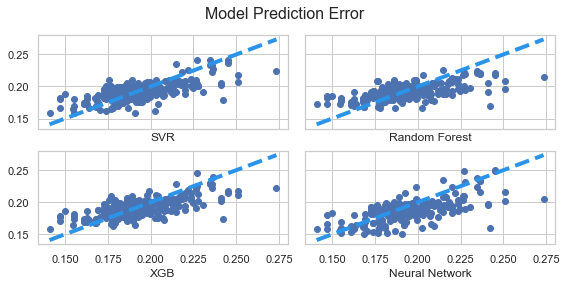

In [563]:
#plot the prediction error
fig, axs = plt.subplots(2,2, figsize=(8,4), sharex=True, sharey=True)
sns.set_style("whitegrid")
axs[0,0].scatter(y_test, SVR1_ypred)
axs[0,1].scatter(y_test, RF_ypred)
axs[1,0].scatter(y_test, XGB2_ypred)
axs[1,1].scatter(y_test, NN_ypred)
# axs[1,1].scatter(y_test, NN_ypred, color='#F2BE2C')

axs[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, c='#2B94E9')
axs[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, c='#2B94E9')
axs[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, c='#2B94E9')
axs[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, c='#2B94E9')

axs[0,0].set_xlabel('SVR', fontsize=12)
axs[0,1].set_xlabel('Random Forest', fontsize=12)
axs[1,0].set_xlabel('XGB', fontsize=12)
axs[1,1].set_xlabel('Neural Network', fontsize=12)

fig.suptitle('Model Prediction Error', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

**Residual Distribution**

In below scatter plots we can see that the residuals have a symmetrical distribution clustered towards the middle of the plot. It is difficult to visually check which model has smaller residuals, therefore I will rely on the RMSE of each of my models to determie the best fit.

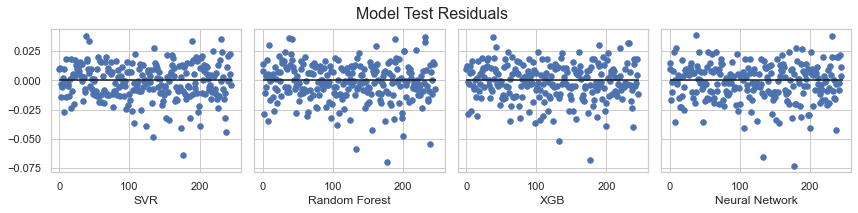

In [302]:
#plot test residuals
fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
sns.set_style("whitegrid")

x_plot = list(range(0, len(y_test))) 
axs[0].scatter(x_plot, SVR1_ypred-y_test, s=30)
axs[0].hlines(y=0, xmin=0, xmax=len(y_test)+1)

axs[1].scatter(x_plot, RF_ypred-y_test, s=30)
axs[1].hlines(y=0, xmin=0, xmax=len(y_test)+1)

axs[2].scatter(x_plot, XGB2_ypred-y_test, s=30)
axs[2].hlines(y=0, xmin=0, xmax=len(y_test)+1)

axs[3].scatter(x_plot, [item[0] for item in NN_ypred]-y_test, s=30)
axs[3].hlines(y=0, xmin=0, xmax=len(y_test)+1)

axs[0].set_xlabel('SVR', fontsize=12)
axs[1].set_xlabel('Random Forest', fontsize=12)
axs[2].set_xlabel('XGB', fontsize=12)
axs[3].set_xlabel('Neural Network', fontsize=12)

fig.suptitle('Model Test Residuals', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

**Random Forest Feature Importance**

Text(0, 0.5, 'Feature')

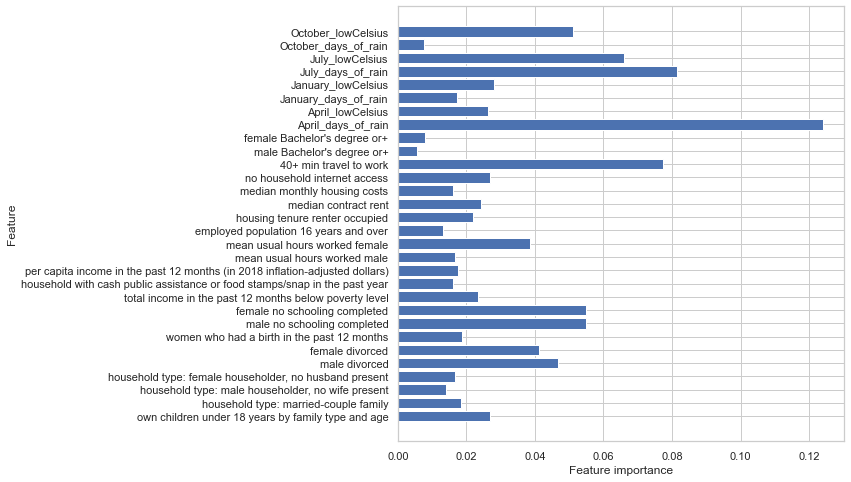

In [411]:
#CREATE A RF TO PLOT FEATURE IMPORTANCES
RF = RandomForestRegressor(max_depth= 6, n_estimators= 1000)
RF.fit(X_train,y_train)

labels = ml_all_data.copy()
labels.drop(labels=['mental_illness_percentage'], inplace=True, axis=1)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), RF.feature_importances_, align='center')
plt.yticks(np.arange(n_features), labels.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')

**Model Selection:** Support Vector Regressor Model with a RMSE of 1.54% and R2 of 0.445

**Next Steps:**
- Tune model parameters to improve RMSE and R2 before moving model to production
- Review dataset to eliminate noise from unnecessary variables 
- Explore further insights from independent variables 

